*torchvision* has dataloaders for common datasets such as Imagenet, CIFAR10, MNIST, etc, and data transformers for images. *torchvision.datasets* and *torch.utils.data.DataLoader*

Transforms are common image transformations. They can be chained together using [*Compose*](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Prepare data

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='/home/aioz-giang/Desktop/Learn/Pytorch/Learn-pytorch/data',
    train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='/home/aioz-giang/Desktop/Learn/Pytorch/Learn-pytorch/data',
    train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


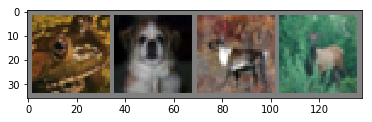

 frog   dog  deer  deer


In [3]:
 def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define Convolutional Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

## Define a Loss function and optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [6]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('epoch: {}, batch: {}. loss:{:.3f}'.format(epoch+1, i+1, running_loss))
            running_loss = 0.0
    print('Finished Training')

epoch: 1, batch: 2000. loss:4395.563
epoch: 1, batch: 4000. loss:3728.831
epoch: 1, batch: 6000. loss:3344.288
epoch: 1, batch: 8000. loss:3158.334
epoch: 1, batch: 10000. loss:3001.452
epoch: 1, batch: 12000. loss:2949.516
Finished Training
epoch: 2, batch: 2000. loss:2777.332
epoch: 2, batch: 4000. loss:2738.042
epoch: 2, batch: 6000. loss:2689.668
epoch: 2, batch: 8000. loss:2602.365
epoch: 2, batch: 10000. loss:2627.549
epoch: 2, batch: 12000. loss:2518.653
Finished Training


## Evaluate 

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
      
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 58 %
Accuracy of  bird : 33 %
Accuracy of   cat : 53 %
Accuracy of  deer : 54 %
Accuracy of   dog : 29 %
Accuracy of  frog : 63 %
Accuracy of horse : 59 %
Accuracy of  ship : 52 %
Accuracy of truck : 78 %


## Training on GPU

Let’s first define our device as the first visible cuda device if we have CUDA available

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


If CUDA device is ready, *.to(device)* will recursively go over all modules and convert their parameters and buffers to CUDA tensors

In [7]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('epoch: {}, batch: {}. loss:{:.3f}'.format(epoch+1, i+1, running_loss))
            running_loss = 0.0
    print('Finished Training')

epoch: 1, batch: 2000. loss:4380.051
epoch: 1, batch: 4000. loss:3676.667
epoch: 1, batch: 6000. loss:3305.047
epoch: 1, batch: 8000. loss:3119.118
epoch: 1, batch: 10000. loss:3006.436
epoch: 1, batch: 12000. loss:2940.027
Finished Training
epoch: 2, batch: 2000. loss:2833.474
epoch: 2, batch: 4000. loss:2770.802
epoch: 2, batch: 6000. loss:2706.230
epoch: 2, batch: 8000. loss:2693.921
epoch: 2, batch: 10000. loss:2640.380
epoch: 2, batch: 12000. loss:2613.413
Finished Training


### Note


**torch.max(*input, dim, keepdim=False, out=None*) -> (Tensor, LongTensor)**

   Returns a namedtuple (`values, indices`) where values is the  maximum `value` of each row of the input tensor in the given dimension `dim`. And `indice`s is the index location of each maximum value found (argmax).

   If `keepdim` is True, the output tensors are of the same size as input except in the dimension `dim` where they are of size 1. Otherwise, `dim` is squeezed